In [ ]:
import os
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
imageSize = 256
batchSize = 16
def prepoc(directory, new_size=(imageSize, imageSize)):
    length=0
    for filename in os.listdir(directory):
      length = length+1;
    images = []
    for i in range (1,length+1):
      for filename in os.listdir(directory):
        index = filename.index(".")
        file = filename[:index]
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            if(i==int(file)):
              image_path = os.path.join(directory, filename)
              image = gdal.Open(image_path)
              image = image.ReadAsArray().astype(np.float32)
              image = np.transpose(image, (1, 2, 0))
              image = tf.image.resize(image, new_size, preserve_aspect_ratio=True)
              image /= 255.0
              images.append(image)
    return images
def convert_to_one_hot(images):
    one_hot_images = []
    for image in images:
        one_hot_image = np.all(image == 1, axis=-1)
        one_hot_image = np.reshape(one_hot_image, (image.shape[0], image.shape[1], 1))
        one_hot_images.append(one_hot_image)
    return one_hot_images
train_images = prepoc("/content/Dataset/train")
train_labels = convert_to_one_hot(prepoc("/content/Dataset/train_labels"))
test_images = prepoc("/content/Dataset/test")
test_labels = convert_to_one_hot(prepoc("/content/Dataset/test_labels"))
val_images = prepoc("/content/Dataset/val")
val_labels = convert_to_one_hot(prepoc("/content/Dataset/val_labels"))

datasets = [train_images, train_labels, test_images, test_labels, val_images, val_labels]
dataset_names = ["train_images", "train_labels", "test_images", "test_labels", "val_images", "val_labels"]
for i, dataset in enumerate(datasets):
    print(f"Dataset: {dataset_names[i]}")
    print(f"Total number of images: {len(dataset)}")
    print(f"Shape of an image: {dataset[0].shape}")
    print("\n")

Dataset: train_images
Total number of images: 137
Shape of an image: (256, 256, 3)


Dataset: train_labels
Total number of images: 137
Shape of an image: (256, 256, 1)


Dataset: test_images
Total number of images: 10
Shape of an image: (256, 256, 3)


Dataset: test_labels
Total number of images: 10
Shape of an image: (256, 256, 1)


Dataset: val_images
Total number of images: 4
Shape of an image: (256, 256, 3)


Dataset: val_labels
Total number of images: 4
Shape of an image: (256, 256, 1)




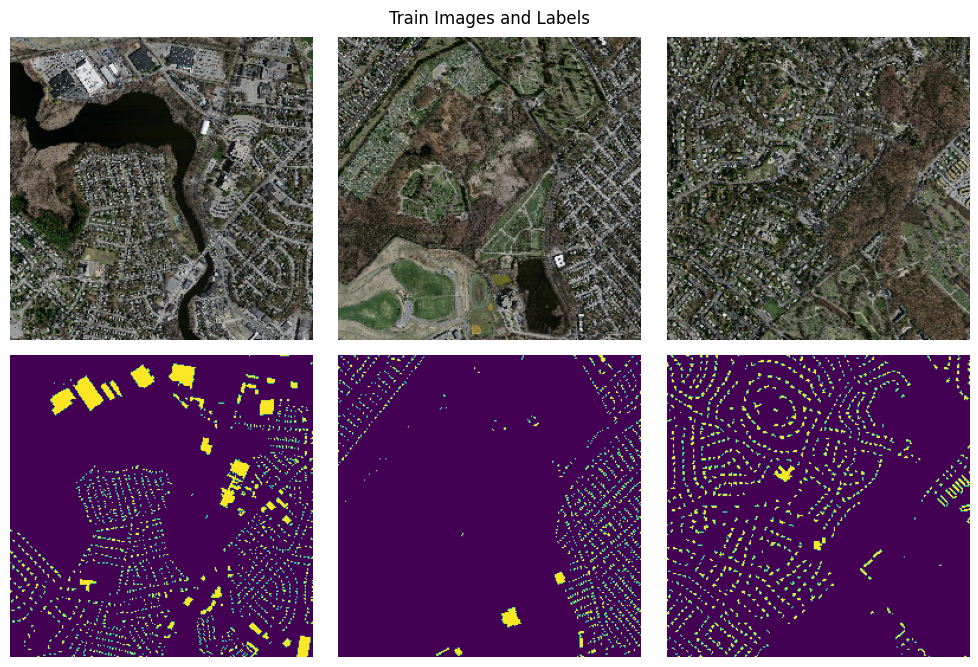

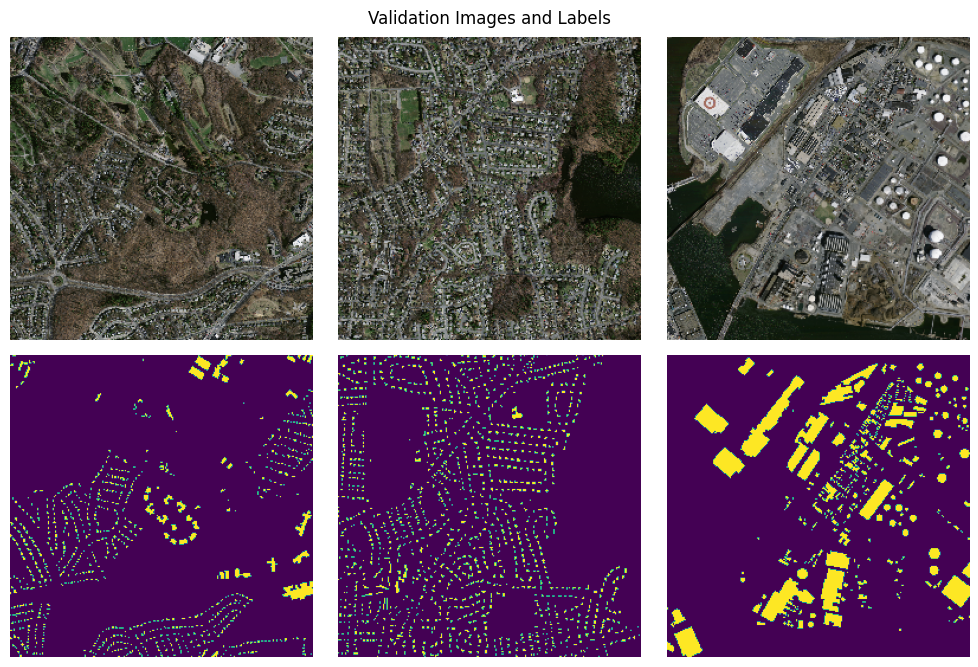

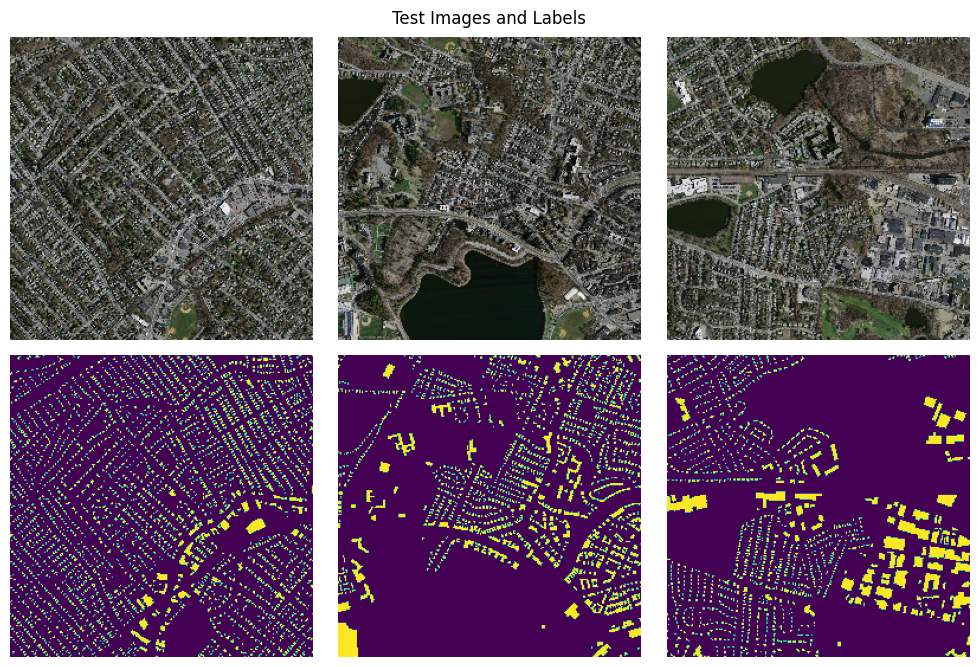

In [ ]:
# PLOT THE IMAGES
# Function to define the plot area
def plot_images(images, labels, title):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(3, 3)  # Create 3 rows and 3 columns

    for i in range(3):
        # Plot image
        ax = plt.subplot(gs[0, i])
        #transposed_image = np.transpose(images[i], (1, 2, 0))
        ax.imshow(images[i])
        ax.axis('off')
        # Plot label
        ax = plt.subplot(gs[1, i])
        #transposed_label = np.transpose(labels[i], (1, 2, 0))
        ax.imshow(labels[i])
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Running the code
plot_images(train_images, train_labels, 'Train Images and Labels')
plot_images(val_images, val_labels, 'Validation Images and Labels')
plot_images(test_images, test_labels, 'Test Images and Labels')

In [ ]:
def create_dataset(images, labels, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if augment:
        # Define data augmentation
        data_augmentation = tf.keras.Sequential([
            #preprocessing.Rescaling(1./255),
            preprocessing.RandomFlip("horizontal_and_vertical"),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
        ])

        # Apply data augmentation to the images
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    return dataset.batch(batchSize)
train_dataset = create_dataset(train_images, train_labels, augment=False)
val_dataset = create_dataset(val_images, val_labels)
test_dataset = create_dataset(test_images, test_labels)

# Print the detail from each datasets
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.bool, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.bool, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.bool, name=None))>


In [ ]:
# DEFINING UNET MODEL
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# UNet Architecture
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model():
    base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = True

   # Select specific layers from ResNet50 to use in your UNet model
    s1 = base_model.get_layer("conv2_block3_out").output
    s2 = base_model.get_layer("conv3_block4_out").output
    s3 = base_model.get_layer("conv4_block6_out").output
    s4 = base_model.get_layer("conv5_block3_out").output

    encoder_layers = [s1, s2, s3, s4]

    num_filters = [32, 64, 128, 256]
    inputs = Input((256, 256, 3))

    skip_x = []
    x = inputs
    ## Encoder
    for i, layer in enumerate(encoder_layers):
        x = conv_block(x, num_filters[i])
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
# IoU
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the UNet model with ResNet50 backbone
model = build_model()  # Use the function name you defined

# Summarize the model architecture
model.summary()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy', iou])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='iou', patience=30, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='iou', factor=0.1, patience=10, min_lr=0.0001, mode='max')

In [ ]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 50,
                    callbacks = [early_stopping, reduce_lr])

NameError: name 'model' is not defined

In [ ]:
# METRIC ASSESMENT
# Evaluate the model on the train dataset
train_loss, train_accuracy, train_iou = model.evaluate(train_dataset)
print(f'Train Accuracy: {train_accuracy}')
print(f'Train IoU: {train_iou}')

# Evaluate the model on the validation dataset
val_loss, val_accuracy, val_iou = model.evaluate(val_dataset)
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation IoU: {val_iou}')

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU: {test_iou}')

9/9 [==============================] - 1s 103ms/step - loss: 0.1721 - accuracy: 0.9331 - iou: 0.3837
Train Accuracy: 0.9331468939781189
Train IoU: 0.38373470306396484
1/1 [==============================] - 0s 38ms/step - loss: 0.2008 - accuracy: 0.9367 - iou: 0.3556
Validation Accuracy: 0.9367332458496094
Validation IoU: 0.35556280612945557
1/1 [==============================] - 0s 76ms/step - loss: 0.2521 - accuracy: 0.9057 - iou: 0.4182
Test Accuracy: 0.9057220220565796
Test IoU: 0.4181647002696991


1/1 [==============================] - 0s 23ms/step


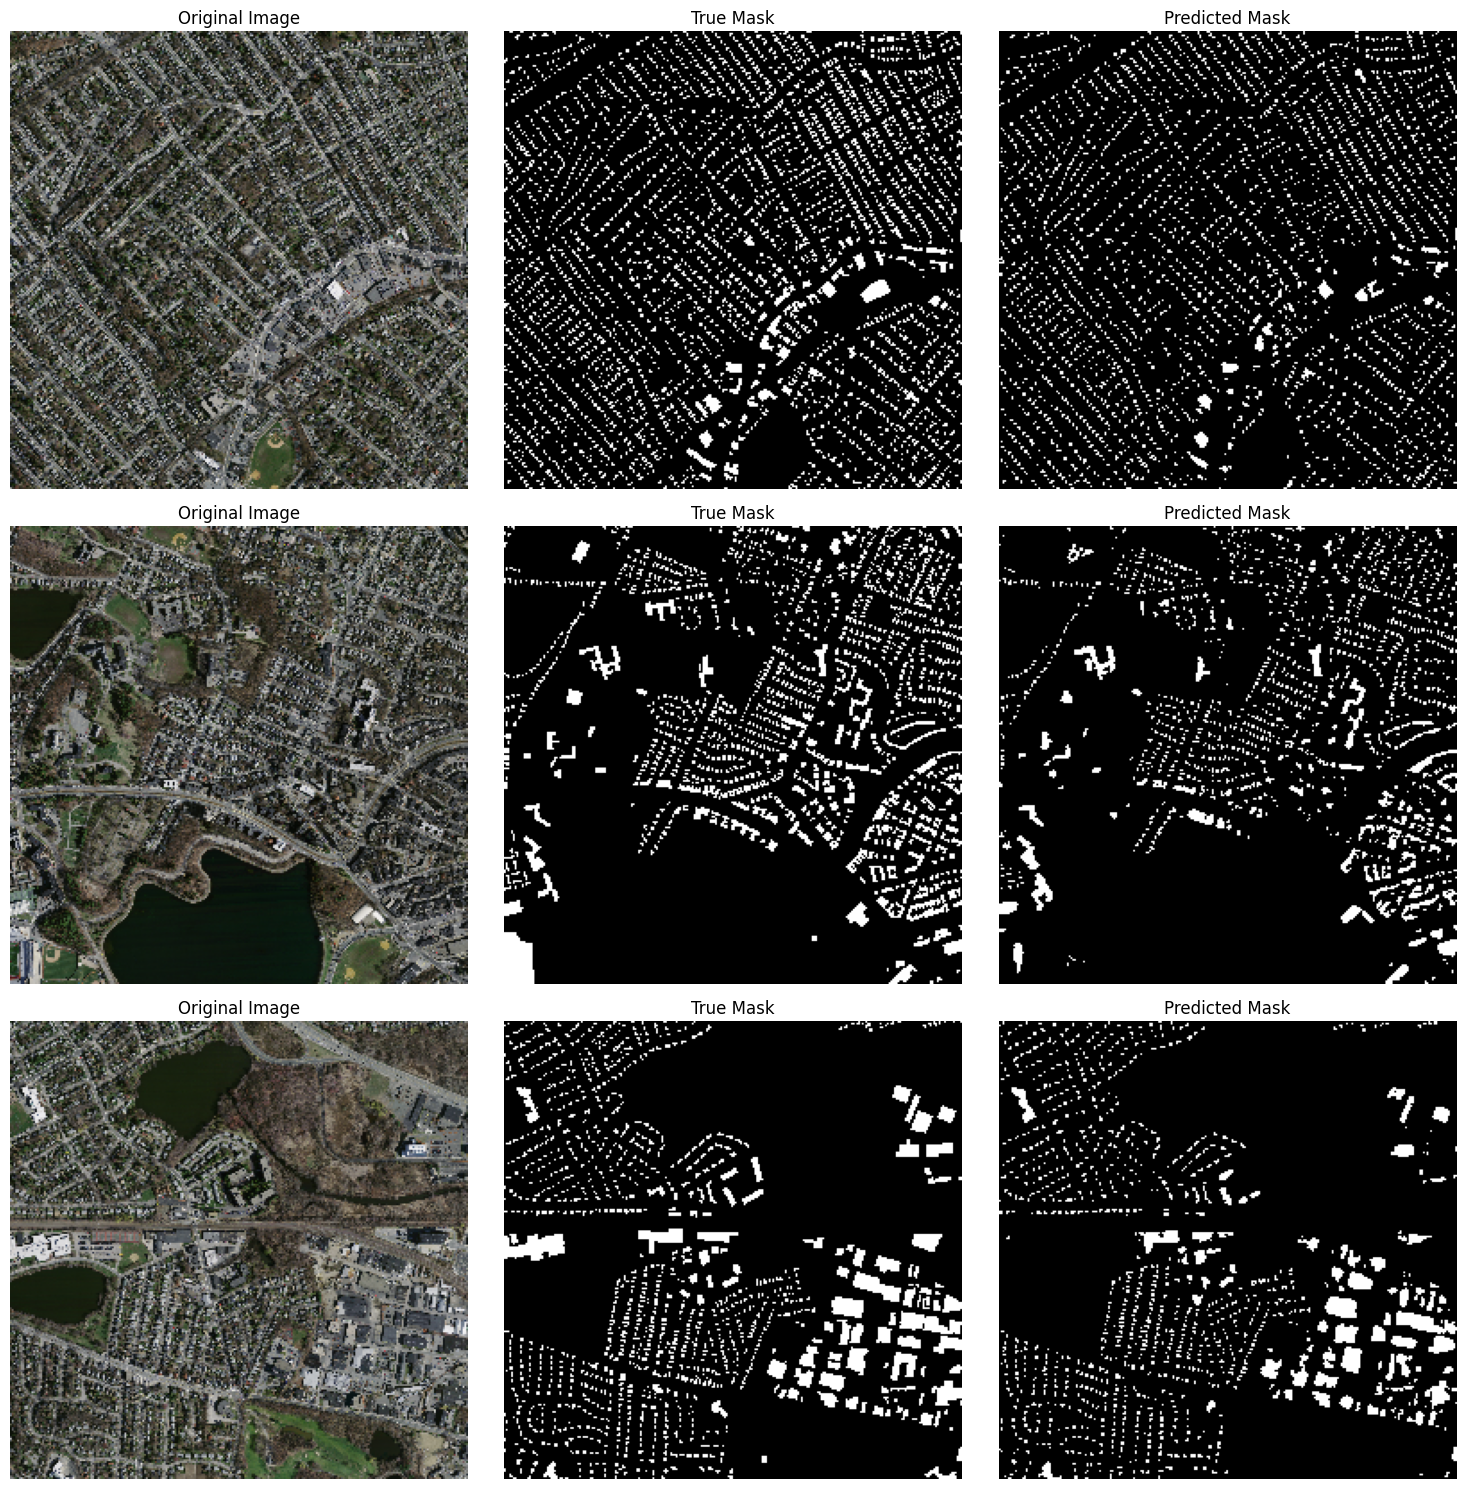

In [ ]:
for images, labels in test_dataset.take(1):
    images = images[:3]
    labels = labels[:3]
    predictions = model.predict(images)

predictions = (predictions > 0.5).astype(np.float32)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    axes[i, 0].imshow(tf.squeeze(image))
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(tf.squeeze(label), cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(tf.squeeze(prediction), cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()